In [4363]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from tqdm import tqdm
from scipy.optimize import root_scalar
import pandas as pd
from IPython.display import HTML



## global variables


In [4364]:

global dt
global psi
global c
global v
global n
global k
global radius
global rho_o
global control_signal
global control_hold
global control_rate
global theta_dot_save
global gamma_save
global alpha_v
global dl
global ds 
global av
global bd_save
global pij_vec_3d
global pij_save
global vis_zone_vec2
global utj_vec
global gamma_ij_glob
global bd_vec_glob
bd_vec_glob = []
gamma_ij_glob = []
utj_vec = []
vis_zone_vec_2 = []
pij_save = []
pij_vec_3d = []
theta_dot_save = []
gamma_save = []
bd_save = []
control_time_delay = 0.1

control_hold = 0
dt = 0.15
control_rate = int(control_time_delay/dt)
control_signal = []


## parameters

In [ ]:
v = 0.3  
av = np.pi/4  
ds = 1  
dl = 4  
psi = np.pi * 7/4  
d_0 = 2.83 
c = 2  
cj = 3  
k = 0.17  
kj = 0.25  
rho_o = 0.8  
n = 5
rho_e_assume = 2

# # if evenly spaced
# d_0 = 2 * rho_e_assume * np.sin(np.pi/n)


## Constraint Checker


solution found, rho_e = 2.0033068269701086
equation 34 angle is 0.7853981633974483, av is 0.7853981633974483 and arcsin(dl/2*rho_e) is 1.5133308841722666
geo_constraint 1 is not met!, 3.9226111866355637 !< 3.141592653589793
geo_constraint 2 met, 1.5686065116190577 > 0.7853981633974483
geo_constraint 3 met, 0.7843032558095289 < 0.7853981633974483
constraint 1 met! the k ratio is 1.4705882352941175, right hand side is 1.5
constraint 2 met!, right hand side is -0.3744822190397537
minimum f equals -0.11580995576134621


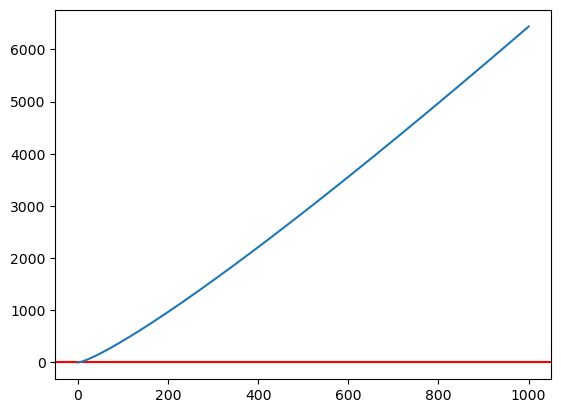

In [4366]:


#rho_e solver using root finding methods
def g_function2(rho_e,c,rho_o):
    g1 = np.log((((c-1)*rho_e) + rho_o)/(c*rho_o))
    if isinstance(rho_e, np.ndarray):
        for i in range(len(rho_e)):
            if rho_e[i] <0.000000001:
                g1[i] = 0
    else:
        if rho_e <0.000000001:
                g1 = 0
    return g1


def f(rho_e):
    return (v/rho_e) - k * g_function2(rho_e, c, rho_o) * (np.pi/2)

rho_guess = 1.0
rho_min = 0.1
rho_max = 200

solution = root_scalar(f, bracket=[rho_min, rho_max], method = 'brentq')
rho_e = solution.root
if solution.converged:
    root = solution.root
    print(f'solution found, rho_e = {root}')
else:
    print('no solution')

# Geometric constraint checker
def geo_constraint1(n, do, rho_e, av, dl):
    # Ensure arcsin argument is within [-1, 1]
    arcsin_input = dl / (2 * rho_e)
    arcsin_input2 = do / (2 * rho_e)
    if np.abs(arcsin_input) > 1 or np.abs(arcsin_input2) > 1:
        print(f"geo_constraint 1 is not met due to invalid arcsin input! 1:{arcsin_input} 2:{arcsin_input2}")
        return
    
    angle = min(av, np.arcsin(arcsin_input))
    print(f"equation 34 angle is {angle}, av is {av} and arcsin(dl/2*rho_e) is {np.arcsin(arcsin_input)}")
    if (n - 1) * np.arcsin(do / (2 * rho_e)) + angle < np.pi:
        print(f"geo_constraint 1 is met!, {(n - 1) * np.arcsin(do / (2 * rho_e)) + angle} < {np.pi}")
    else:
        print(f"geo_constraint 1 is not met!, {(n - 1) * np.arcsin(do / (2 * rho_e)) + angle} !< {np.pi}")

def geo_constraint2(do, rho_e, av, dl):
    # Ensure arcsin argument is within [-1, 1]
    arcsin_input = dl / (2 * rho_e)
    arcsin_input2 = do / (2 * rho_e)
    if np.abs(arcsin_input) > 1 or np.abs(arcsin_input2) > 1:
        print(f"geo_constraint 2 is not met due to invalid arcsin input! 1:{arcsin_input} 2:{arcsin_input2}")
        return
    
    angle = min(av, np.arcsin(arcsin_input))
    if 2 * np.arcsin(do / (2 * rho_e)) > angle:
        print(f"geo_constraint 2 met, {2 * np.arcsin(do / (2 * rho_e))} > {angle}")
    else:
        print(f"geo_constraint 2 not met, {2 * np.arcsin(do / (2 * rho_e))} !> {angle}")

def geo_constraint3(do, rho_e, av):
    # Ensure arcsin argument is within [-1, 1]
    arcsin_input = do / (2 * rho_e)
    if np.abs(arcsin_input) > 1:
        print(f"geo_constraint 3 is not met due to invalid arcsin input! 1:{arcsin_input}")
        return
    
    if np.arcsin(do / (2 * rho_e)) < av:
        print(f"geo_constraint 3 met, {np.arcsin(do / (2 * rho_e))} < {av}")
    else:
        print(f"geo_constraint 3 not met, {np.arcsin(do / (2 * rho_e))} !< {av}")


# Test functions with your parameters
geo_constraint1(n, d_0, rho_e, av, dl)
geo_constraint2(d_0, rho_e, av, dl)
geo_constraint3(d_0, rho_e, av)

# constraint checker

def constraint1(k,kj,c,cj):
    if kj/k <= 2 * (cj/c) * ((c-1)/(cj-1)):
        print(f"constraint 1 met! the k ratio is {kj/k}, right hand side is {2 * (cj/c) * ((c-1)/(cj-1))}")
        return True
    else:
        print(f"constraint1 not met! the k ratio is {kj/k}, right hand side is {2 * (cj/c) * ((c-1)/(cj-1))}")
        return False

# constraint 2: all f values must be greater than (-2 * v) / (3 * np.pi * k) (equation 13)
def constraint2(g_function, c, rho_o, v, k):
    global coord 
    rho = np.arange(0,1000,0.01)
    f = rho * g_function(rho,c,rho_o)
    if all(f > (-2 * v) / (3 * np.pi * k)):
        print(f'constraint 2 met!, right hand side is {(-2 * v) / (3 * np.pi * k)}')
        print(f"minimum f equals {min(f)}")
    else:
        print(f'constraint 2 not met, right hand side is {(-2 * v) / (3 * np.pi * k)}')
        print(f"minimum f equals {min(f)}")
    
    plt.figure()
    plt.axhline(y = (-2 * v) / (3 * np.pi * k), color = 'r')
    plt.plot(rho, f)
    plt.show()
    coord = f

constraint1(k,kj,c,cj)
constraint2(g_function2,c, rho_o, v, k)

Dynamics :

$\dot{x}(t) = v\cos \theta (t)\\$
$\dot{y}(t) = v\sin \theta (t)\\$
$\dot{theta}(t) = u(t)\\$

Control Law for one vehicle : 

$$
    u(t)= 
\begin{cases}
    k \cdot g(\rho (t) ; c,\rho_0) \cdot \alpha_d(\gamma(t)) ,& \text{if } \rho(t) > 0\\
    0,              & \text{if } \rho(t) = 0
\end{cases} \\
$$
with
$$
g(\rho ; c,\rho_0) = ln\Big (\frac{(c-1)\cdot \rho + \rho_0}{c \cdot \rho_0}\Big )\\
$$

$$
\alpha_d(\gamma) = \begin{cases}
    \gamma ,& \text{if } 0 \leq \gamma \leq \psi\\
    \gamma - 2 \pi,              & \text{if } \psi < \gamma \leq 2 \pi
\end{cases} \\
$$

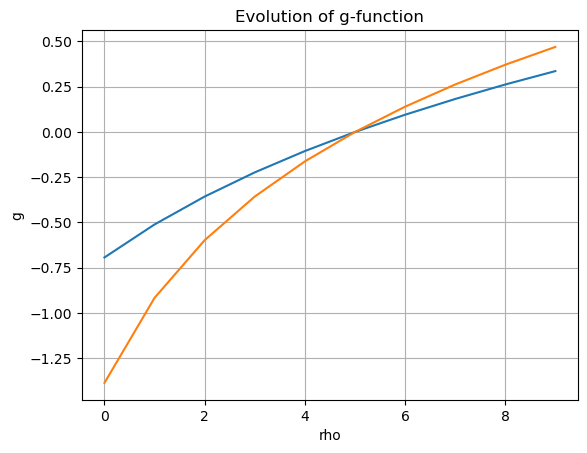

In [4367]:
op1 = []
op2 = []
var_0 = 5
var_c1 = 2
var_c2 = 4
for var in range(10):
    op1.append(np.log((((var_c1-1)*var) + var_0)/(var_c1*var_0)))
    op2.append(np.log((((var_c2-1)*var) + var_0)/(var_c2*var_0)))
plt.plot(op1)
plt.plot(op2)

plt.title("Evolution of g-function")
plt.grid(True)
plt.xlabel('rho')
plt.ylabel('g')
plt.show()


## Code Block for the multi-agent controller

In [4368]:
def dist(a,b):
    d = np.array(a) - np.array(b)
    d = np.linalg.norm(d)
    return d

def get_angle(dx,dy):
    theta = np.arctan2(dy,dx)
    if(theta<0):
        theta = theta + 2*np.pi
    return theta

def get_angle_j(agent_vec,pij_vec):
    det = agent_vec[0] * pij_vec[1] - agent_vec[1] * pij_vec[0]
    dot = agent_vec[0] * pij_vec[0] + agent_vec[1] * pij_vec[1]
    theta = np.arctan2(det,dot)
    # tolerance = 1e-10
    # if abs(theta) < tolerance:
    #     theta = 0.0
    
    if theta < 0:
        theta += 2 * np.pi
    return theta

def g_function_j(pij, cv, do):
    g = np.log((((cv-1)*pij) + do)/(cv*do))
    if (pij<0.000000001):
        g = 0
    return g

    

# Controller for collision prevention

def Bd(gamma_ij):
    bd = []
    for i in range(len(gamma_ij)):
        gamma_ij_target = gamma_ij[i]
        if ((gamma_ij_target>=0) and (gamma_ij_target <= np.pi)):
            bd.append(gamma_ij_target)
        elif ((gamma_ij_target > np.pi)and (gamma_ij_target < 2*np.pi)):
            bd.append(gamma_ij_target - 2*np.pi)
        else :
            print("Error in gamma_ij value" + str(gamma_ij_target))
            bd.append(gamma_ij_target - 2*np.pi)
    bd_save.append(bd)
    return bd

def pij(x, n, agent_coord,agent_index):
    counter = 0
    pij = []
    pij_debug = []
    
    for i in range(n):
        if i == agent_index: 
            continue
        # print(f"Agent {i}: Comparing {agent_coord[0:2]} with {x[counter:counter+2]}")  # Debug print
        pij_magnitude = dist(agent_coord[0:2], x[3*i:3*i+2])  # Check distances
        # print(f"Distance for agent {i}: {pij_magnitude}")  # Debug the calculated distance
        
        pij_debug.append(pij_magnitude)
        pij.append(pij_magnitude)
        # Skip over x, y, theta
    
    pij_save.append(pij_debug)
    return pij


def gamma_ij(x,n,agent_coord,agent_index):
    
    gamma_ij_vec = []
    theta_agent = agent_coord[2]
    agent_vec = [np.cos(theta_agent),np.sin(theta_agent)]
    for i in range(n):
        if i == agent_index:
            continue
        pij_vector = x[3*i:3*i+2] - agent_coord[0:2]
        # pij_theta = get_angle(pij_vector[1],pij_vector[0])
        gamma_ij = get_angle_j(agent_vec,pij_vector)
        
        # print(f"pij theta = {pij_theta}")
        # print(f"agent coord = {theta_agent}")
        # gamma_ij = pij_theta - theta_agent
        gamma_ij_vec.append(gamma_ij)
    return gamma_ij_vec

def visibility_zone_detector(dl,ds,alpha_v,Bd_vec,pij):  # call in u_t_j
    visible = []
    #v_vector = [v*np.cos(theta), v*np.sin(theta)]
    for i in range(len(pij)):
        if pij[i] < ds:
            visible.append(True)
            continue
        elif ((pij[i] <= dl) and (abs(Bd_vec[i]) <= alpha_v)):
            visible.append(True)
        else:
            visible.append(False)
    return visible

def u_t_j(pij,b_d,cv,do,kv,visible): # return 0 when none within range_finder
    u_ij = []
    for i in range(len(visible)):
        # print(f"bd is {b_d}")
        # print(f"visible is {visible}")
        if visible[i]:
            bij = b_d[i]
            gij = g_function_j(pij[i],cv,do)
            u_ij.append(kv*gij*bij)
    u = sum(u_ij)
    return u

                
    


In [4369]:


def g_function(xb,xv,c,rho_o):
    rho_v = np.array(xb) - np.array(xv)
    rho = np.linalg.norm(rho_v)
    g = np.log((((c-1)*rho) + rho_o)/(c*rho_o))
    if (rho<0.000000001):
        g = 0
    return g

def alpha_d(gamma,psi):
    if ((gamma>=0)and (gamma <=psi)):
        return gamma
    elif ((gamma>psi)and (gamma <2*np.pi)):
        return gamma - 2*np.pi
    else :
        print("Error in gamma value" + str(gamma))
        return 0.0


def u_t(xv,xb,heading):
    gamma = get_angle(xb[0] - xv[0],xb[1] - xv[1]) - heading
    while (gamma>2*np.pi):
        gamma = gamma -2*np.pi
    while (gamma<0):
        gamma = gamma + 2*np.pi
    #print(np.rad2deg(gamma))
    alpha = alpha_d(gamma,psi)

    g = g_function(xb,xv,c,rho_o)
    # print(f"g is {g}")
    # print(f'alpha is {alpha}')
    u = k*g*alpha
    if dist(xv,xb) < 0.1:
        u = 0
    control_signal.append(u)
    return u


def gamma_angle(xv,xb,heading):
    gamma = get_angle(xb[0] - xv[0],xb[1] - xv[1]) - heading
    while (gamma>2*np.pi):
        gamma = gamma -2*np.pi
    while (gamma<0):
        gamma = gamma + 2*np.pi
    return gamma

def velocity(t,n):
    return np.ones(n)*v
def adjust_angle(x,n):
    for i in range (n):
        while (x[(3*i)+2]>2*np.pi):
            x[(3*i)+2] = x[(3*i)+2] -2*np.pi
        while (x[(3*i)+2]<0):
            x[(3*i)+2] = x[(3*i)+2] + 2*np.pi
    return x

def f_unicycle(t,x,n):
    xb = np.array([0 , 0])
    v_vec = velocity(t,n)
    visible = None
    pij_vec = None
    utj = None
    pij_vec_2 = []
    gamma_ij_vec = None
    theta_dot_vec = []
    gamma_vec = []
    vis_zone_vec = []
    utj_save = []
    gamma_ij_save = []
    Bd_vec_save = []
    Bd_vec = None
    for i in range(n):
        gamma_ij_vec = (gamma_ij(x,n,x[3*i:(3*i)+3],i))
        gamma_ij_save.append(gamma_ij_vec)
        Bd_vec = Bd(gamma_ij_vec)
        Bd_vec_save.append(Bd_vec)
        pij_vec = pij(x,n,x[3*i:(3*i)+3],i)
        pij_vec_2.append(pij_vec)
        visible = visibility_zone_detector(dl,ds,av,Bd_vec,pij_vec)
        vis_zone_vec.append(visible)
        utj = u_t_j(pij_vec,Bd_vec,cj,d_0,kj,visible)
        utj_save.append(utj)
        theta_dot_vec.append(u_t(x[3*i:(3*i)+2],xb,x[(3*i)+2]) + utj)
        # gamma_vec.append(gamma_angle(x[3*i:(3*i)+2],xb,x[(3*i)+2]) + u_t_j(x[3*i:(3*i)+2],x[3*((i+1)%n):(3*((i+1)%n))+2],x[(3*i)+2]))
        gamma_vec.append(gamma_angle(x[3*i:(3*i)+2],xb,x[(3*i)+2]))
    gamma_ij_glob.append(gamma_ij_save)
    bd_vec_glob.append(Bd_vec_save)
    utj_vec.append(utj_save)
    vis_zone_vec_2.append(vis_zone_vec)
    pij_vec_3d.append(pij_vec_2)
    rhs = []
    theta_dot_save.append(theta_dot_vec)
    gamma_save.append(gamma_vec)

    for i in range(n):
        v = v_vec[i]
        theta_dot = theta_dot_vec[i]
        theta = x[(3*i) + 2]
        rhs.append([(v*np.cos(theta)),(v*np.sin(theta)),(theta_dot)])
    #theta_dot_save
    # print(rhs)
    rhs = np.array(rhs)
    rhs = rhs.flatten()
    return rhs
    # return theta_dot_vec

def rk4_step(f,x,t,dt,n):
    k1 = f(t,x,n)
    k2 = f(t + (0.5*dt),x + (0.5*k1*dt),n)
    k3 = f(t + (0.5*dt),x + (0.5*k2*dt),n)
    k4 = f(t + dt,x + (k3*dt),n)

    return dt*((k1 + (2*k2) + (2*k3) + k4)/6)


def get_angle(dx,dy):
    theta = np.arctan2(dy,dx)
    if(theta<0):
        theta = theta + 2*np.pi
    return theta


# def get_theta_dot(T,dt,t,x,n):
#     theta_dot = []
#     thet_dot = []
#     for i in tqdm(range(int(T/dt))):
#         thet_dot = f_unicycle(t,x,n)
#         x = x + dx
#         x = adjust_angle(x,n)
#         t = t + dt
#         theta_dot.append(thet_dot)
#     theta_dot = np.array(theta_dot)
#     return theta_dot




In [4370]:
offset = 0
x0_5agent = np.array([-6,1.6,0,
               -6,2.6,0,
               -6,3.6,0,
               -6,4.6,0,
               -6,5.6,0])
x0_4agent = np.array([-6,1.6,0,
               -6,-0.6,0,
               -6,0.6,0,
               -6,-1.6,0])


x0_3agent = np.array([-2.2,1,0,
               2.2,0,0,
               -2.2,-1,0])

x0_2agent = np.array([0,0,0,
               -3, -3,0])

x0_1agent = np.array([-2.333,-1.183,0])



# x0 = np.array([0,0,0,
#                5,0,0.2,
#                3,7,0.3,
#                -2,8,0.4])

# x0 = np.array([2,0,1.57])
# x0 = np.array([0,0,1.57])
# n = 4

#2 agents
"""
traj = [x0_2agent]
x = x0_2agent
"""

# 3 agents
"""
traj = [x0_3agent]
x = x0_3agent
"""

# 4 agents
"""
traj = [x0_4agent]
x = x0_4agent
"""

# 5 agents
#"""
traj = [x0_5agent]
x = x0_5agent
#"""

t = 0
T = 1000
# global counter
# counter = 0

for i in tqdm(range(int(T/dt) )):
    dx = rk4_step(f_unicycle,x,t,dt,n)
    x = x + dx
    x = adjust_angle(x,n)
    t = t + dt
    traj.append(x)
    # counter += counter + 1 



100%|██████████| 6666/6666 [00:11<00:00, 573.46it/s]


In [4371]:
# print("Velocity : ", v)
# plt.plot(np.array(traj)[:,2])
# plt.title("Controls")
# plt.grid(True)
# plt.ylabel("radius (m)")
# plt.show()

In [4372]:
# plt.plot(np.array(traj)[:,2])
# plt.title("Controls")
# plt.grid(True)
# plt.ylabel("radius (m)")
# plt.show()

## controller input plot for each agent

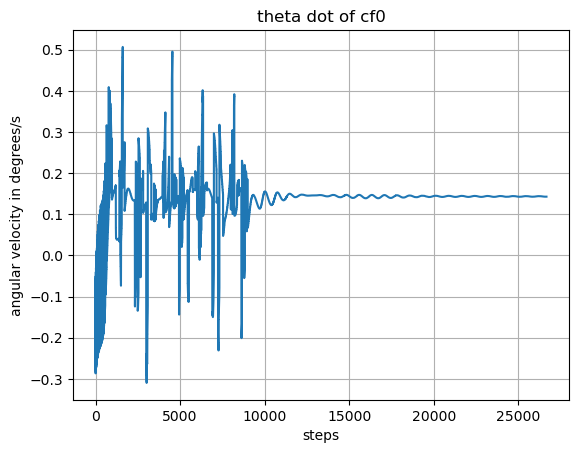

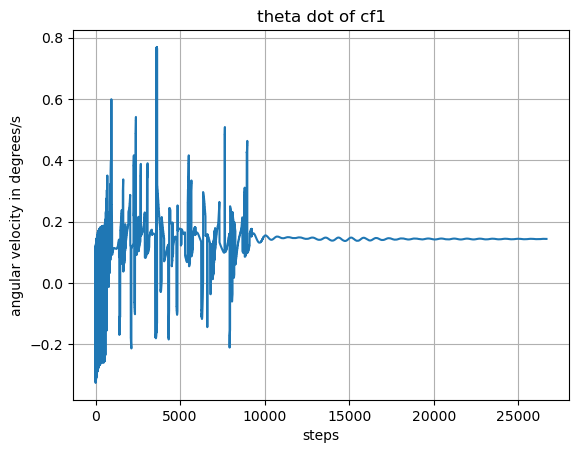

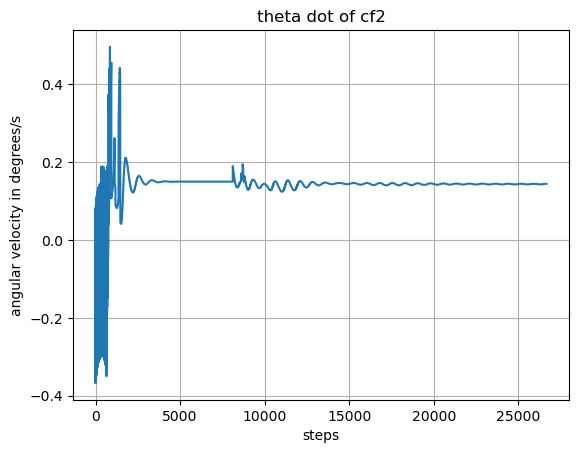

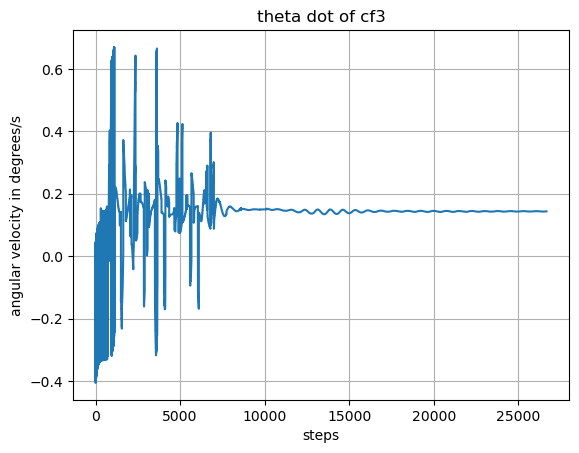

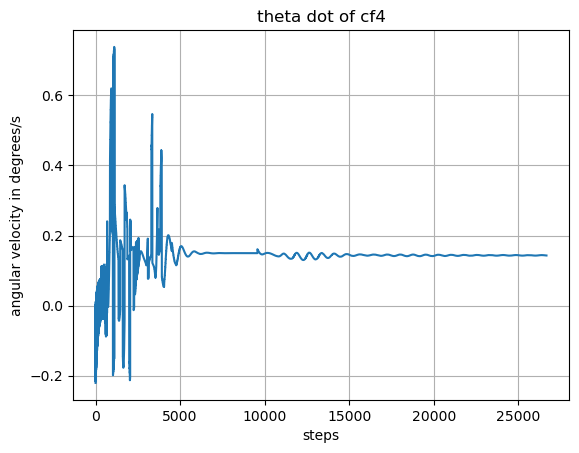

In [4373]:
for i in range(n):
    plt.plot(np.array(theta_dot_save)[:,i]) # on the left
    plt.title(f"theta dot of cf{i}")
    plt.grid(True)
    plt.xlabel('steps')
    plt.ylabel('angular velocity in degrees/s')
    plt.show()

In [4374]:
# plt.plot(np.array(traj)[0:5000,2])
print(type(traj))

<class 'list'>


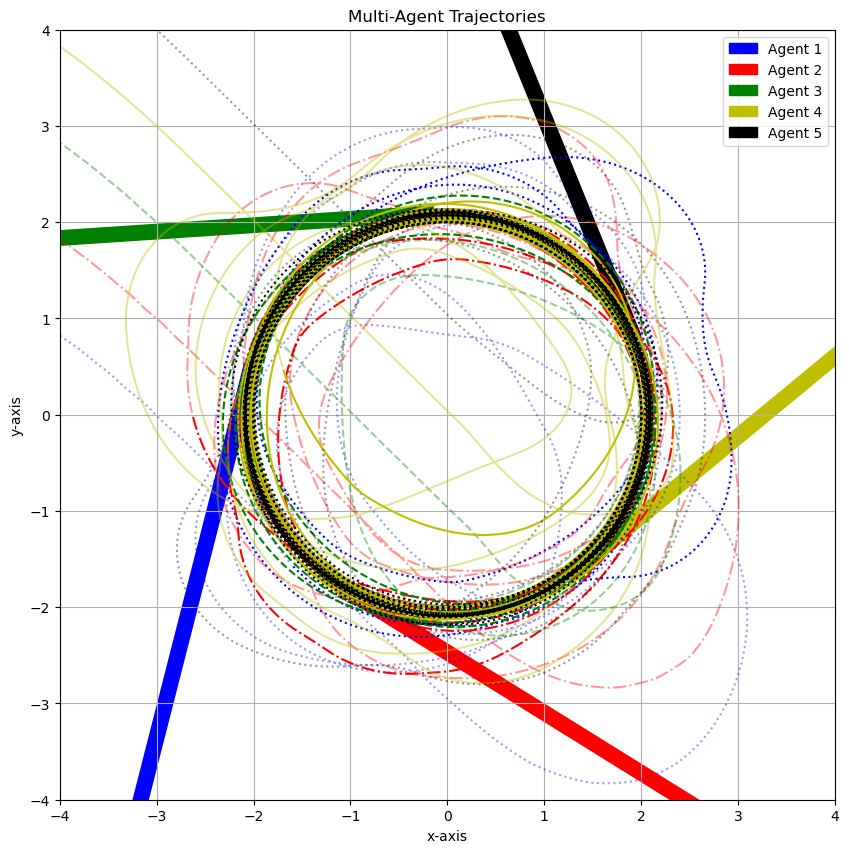

Final coord Agent 1: [-2.02088724  0.50893745]
Final coord Agent 2: [-1.1177976  -1.77097221]
Final coord Agent 3: [-0.14200445  2.09252789]
Final coord Agent 4: [ 1.34350333 -1.60161106]
Final coord Agent 5: [1.93767444 0.77379342]
Distance between Agent 4 and Agent 5: 2.4485885251352912


In [4375]:
def distance(a, b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

# Setup
display_horizon = 5000
traj = np.array(traj)
n_states = traj.shape[1]
n_agents = n_states // 3  # each agent has [x, y, theta]

# Plot setup
plt.figure(figsize=(10, 10))
colors = ['b', 'r', 'g', 'y', 'k', 'm', 'c']  # extend this if more agents
linestyles = [':', '-.', '--', '-']  # cycle if needed
arrow_size = 5 if n_agents > 3 else 3  # scale arrows based on agent count

# Loop over each agent
for i in range(n_agents):
    x_idx = i * 3
    y_idx = x_idx + 1
    theta_idx = x_idx + 2
    color = colors[i % len(colors)]
    style = linestyles[i % len(linestyles)]
    
    # Plot past trajectory
    plt.plot(traj[:-display_horizon, x_idx], traj[:-display_horizon, y_idx], style, alpha=0.4, color=color)
    # Plot recent trajectory
    plt.plot(traj[-display_horizon:-1, x_idx], traj[-display_horizon:-1, y_idx], style, alpha=1, color=color)

    # Final arrow (orientation)
    x, y, theta = traj[-1, x_idx], traj[-1, y_idx], traj[-1, theta_idx]
    plt.arrow(x, y, arrow_size*np.cos(theta), arrow_size*np.sin(theta), 
              width=0.15, color=color, label=f'Agent {i+1}')

# Formatting
plt.title('Multi-Agent Trajectories')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend()
plt.grid()
plt.axis([-4,4,-4,4])
# plt.axis('auto')  # or customize bounds with plt.axis([xmin, xmax, ymin, ymax])
plt.show()

# Final positions
final_coords = [traj[-1, i*3:i*3+2] for i in range(n_agents)]
for i, coord in enumerate(final_coords):
    print(f"Final coord Agent {i+1}: {coord}")

# Example distance between last two agents (if >=2)
if n_agents >= 2:
    d = distance(final_coords[-1], final_coords[-2])
    print(f"Distance between Agent {n_agents-1} and Agent {n_agents}: {d}")


In [4376]:
# def distance(a,b):
#     d = np.sqrt(((a[0]-b[0])**2)+((a[1]-b[1])**2))
#     return d

# plt.figure(figsize=(10,10))

# # plt.plot(np.array(traj)[:,0],np.array(traj)[:,1])
# # plt.plot(np.array(traj)[:,2],np.array(traj)[:,3])
# # plt.plot(np.array(traj)[:,4],np.array(traj)[:,5])
# # plt.plot(np.array(traj)[:,6],np.array(traj)[:,7])
# # plt.axis('equal')
# # plt.show()

# #5 agents 
# '''
# display_horizon = 5000
# plt.plot(np.array(traj)[0:-display_horizon,0],np.array(traj)[0:-display_horizon,1],':',alpha = 0.4)
# plt.plot(np.array(traj)[0:-display_horizon,3],np.array(traj)[0:-display_horizon,4],'-.',alpha = 0.4)
# plt.plot(np.array(traj)[0:-display_horizon:,6],np.array(traj)[0:-display_horizon,7],'--',alpha = 0.4)
# plt.plot(np.array(traj)[0:-display_horizon,9],np.array(traj)[0:-display_horizon,10],alpha = 0.4)
# plt.plot(np.array(traj)[0:-display_horizon,12],np.array(traj)[0:-display_horizon,13],alpha = 0.4)


# plt.plot(np.array(traj)[-display_horizon:-1,0],np.array(traj)[-display_horizon:-1,1],':',alpha = 1)
# plt.plot(np.array(traj)[-display_horizon:-1,3],np.array(traj)[-display_horizon:-1,4],'-.',alpha = 1)
# plt.plot(np.array(traj)[-display_horizon:-1,6],np.array(traj)[-display_horizon:-1,7],'--',alpha = 1)
# plt.plot(np.array(traj)[-display_horizon:-1,9],np.array(traj)[-display_horizon:-1,10],alpha = 1)
# plt.plot(np.array(traj)[-display_horizon:-1,12],np.array(traj)[-display_horizon:-1,13],alpha = 1)
# plt.axis('equal')
# plt.title('Q2')
# plt.xlabel('x-axis')
# plt.ylabel('y-axis')

# arrow_size = 10
# plt.arrow(np.array(traj)[-1,0],np.array(traj)[-1,1],arrow_size*np.cos(np.array(traj)[-1,2]),arrow_size*np.sin(np.array(traj)[-1,2]),width=.2,label = '1',color = 'b')
# plt.arrow(np.array(traj)[-1,3],np.array(traj)[-1,4],arrow_size*np.cos(np.array(traj)[-1,5]),arrow_size*np.sin(np.array(traj)[-1,5]),width=.2,label = '2',color = 'r')
# plt.arrow(np.array(traj)[-1,6],np.array(traj)[-1,7],arrow_size*np.cos(np.array(traj)[-1,8]),arrow_size*np.sin(np.array(traj)[-1,8]),width=.2,label = '3',color = 'g')
# plt.arrow(np.array(traj)[-1,9],np.array(traj)[-1,10],arrow_size*np.cos(np.array(traj)[-1,11]),arrow_size*np.sin(np.array(traj)[-1,11]),width=.2,label = '4',color = 'y')
# plt.arrow(np.array(traj)[-1,12],np.array(traj)[-1,13],arrow_size*np.cos(np.array(traj)[-1,14]),arrow_size*np.sin(np.array(traj)[-1,14]),width=.2,label = '4',color = 'k')
# plt.legend()
# plt.grid()
# plt.axis([-30,30,-30,30])
# plt.show()

# print(f"final coordinate {traj[-1][:]}")
# a_coord = traj[-1][0:2] #blue 
# b_coord = traj[-1][3:5] #red
# c_coord = traj[-1][6:8] #green
# d_coord = traj[-1][9:11] #yellow
# d = distance(c_coord,d_coord)
# print(f"actual do = {d}")
# '''

# #4 agents 
# #'''
# display_horizon = 5000
# plt.plot(np.array(traj)[0:-display_horizon,0],np.array(traj)[0:-display_horizon,1],':',alpha = 0.4)
# plt.plot(np.array(traj)[0:-display_horizon,3],np.array(traj)[0:-display_horizon,4],'-.',alpha = 0.4)
# plt.plot(np.array(traj)[0:-display_horizon,6],np.array(traj)[0:-display_horizon,7],'--',alpha = 0.4)
# plt.plot(np.array(traj)[0:-display_horizon,9],np.array(traj)[0:-display_horizon,10],alpha = 0.4)

# plt.plot(np.array(traj)[-display_horizon:-1,0],np.array(traj)[-display_horizon:-1,1],':',alpha = 1)
# plt.plot(np.array(traj)[-display_horizon:-1,3],np.array(traj)[-display_horizon:-1,4],'-.',alpha = 1)
# plt.plot(np.array(traj)[-display_horizon:-1,6],np.array(traj)[-display_horizon:-1,7],'--',alpha = 1)
# plt.plot(np.array(traj)[-display_horizon:-1,9],np.array(traj)[-display_horizon:-1,10],alpha = 1)
# plt.axis('equal')
# plt.title('Q2')
# plt.xlabel('x-axis')
# plt.ylabel('y-axis')

# arrow_size = 10
# plt.arrow(np.array(traj)[-1,0],np.array(traj)[-1,1],arrow_size*np.cos(np.array(traj)[-1,2]),arrow_size*np.sin(np.array(traj)[-1,2]),width=.2,label = '1',color = 'b')
# plt.arrow(np.array(traj)[-1,3],np.array(traj)[-1,4],arrow_size*np.cos(np.array(traj)[-1,5]),arrow_size*np.sin(np.array(traj)[-1,5]),width=.2,label = '2',color = 'r')
# plt.arrow(np.array(traj)[-1,6],np.array(traj)[-1,7],arrow_size*np.cos(np.array(traj)[-1,8]),arrow_size*np.sin(np.array(traj)[-1,8]),width=.2,label = '3',color = 'g')
# plt.arrow(np.array(traj)[-1,9],np.array(traj)[-1,10],arrow_size*np.cos(np.array(traj)[-1,11]),arrow_size*np.sin(np.array(traj)[-1,11]),width=.2,label = '4',color = 'y')
# plt.legend()
# plt.grid()
# plt.axis([-20,20,-20,20])
# plt.show()

# print(f"final coordinate {traj[-1][:]}")
# a_coord = traj[-1][0:2] #blue 
# b_coord = traj[-1][3:5] #red
# c_coord = traj[-1][6:8] #green
# d_coord = traj[-1][9:11] #yellow
# d = distance(c_coord,d_coord)
# print(f"actual do = {d}")
# #'''

# # 3 agents
# """
# display_horizon = 5000
# plt.plot(np.array(traj)[0:-display_horizon,0],np.array(traj)[0:-display_horizon,1],':',alpha = 0.4)
# plt.plot(np.array(traj)[0:-display_horizon,3],np.array(traj)[0:-display_horizon,4],'-.',alpha = 0.4)
# plt.plot(np.array(traj)[0:-display_horizon:,6],np.array(traj)[0:-display_horizon,7],'--',alpha = 0.4)

# plt.plot(np.array(traj)[-display_horizon:-1,0],np.array(traj)[-display_horizon:-1,1],':',alpha = 1)
# plt.plot(np.array(traj)[-display_horizon:-1,3],np.array(traj)[-display_horizon:-1,4],'-.',alpha = 1)
# plt.plot(np.array(traj)[-display_horizon:-1,6],np.array(traj)[-display_horizon:-1,7],'--',alpha = 1)
# plt.axis('equal')
# plt.title('Q2')
# plt.xlabel('x-axis')
# plt.ylabel('y-axis')

# arrow_size = 3
# plt.arrow(np.array(traj)[-1,0],np.array(traj)[-1,1],arrow_size*np.cos(np.array(traj)[-1,2]),arrow_size*np.sin(np.array(traj)[-1,2]),width=.25,label = '1',color = 'b')
# plt.arrow(np.array(traj)[-1,3],np.array(traj)[-1,4],arrow_size*np.cos(np.array(traj)[-1,5]),arrow_size*np.sin(np.array(traj)[-1,5]),width=.25,label = '2',color = 'r')
# plt.arrow(np.array(traj)[-1,6],np.array(traj)[-1,7],arrow_size*np.cos(np.array(traj)[-1,8]),arrow_size*np.sin(np.array(traj)[-1,8]),width=.25,label = '3',color = 'g')
# plt.legend()
# plt.grid()
# plt.axis([-3,3,-3,3])
# plt.show()
# """

# #2 agents
# """
# display_horizon = 5000
# plt.plot(np.array(traj)[0:-display_horizon,0],np.array(traj)[0:-display_horizon,1],':',alpha = 0.4)
# plt.plot(np.array(traj)[0:-display_horizon,3],np.array(traj)[0:-display_horizon,4],'-.',alpha = 0.4)

# plt.plot(np.array(traj)[-display_horizon:-1,0],np.array(traj)[-display_horizon:-1,1],':',alpha = 1)
# plt.plot(np.array(traj)[-display_horizon:-1,3],np.array(traj)[-display_horizon:-1,4],'-.',alpha = 1)
# plt.axis('equal')
# plt.title('Q2')
# plt.xlabel('x-axis')
# plt.ylabel('y-axis')

# arrow_size = 3
# plt.arrow(np.array(traj)[-1,0],np.array(traj)[-1,1],arrow_size*np.cos(np.array(traj)[-1,2]),arrow_size*np.sin(np.array(traj)[-1,2]),width=.025,label = '1',color = 'b')
# plt.arrow(np.array(traj)[-1,3],np.array(traj)[-1,4],arrow_size*np.cos(np.array(traj)[-1,5]),arrow_size*np.sin(np.array(traj)[-1,5]),width=.025,label = '2',color = 'r')
# plt.legend()
# plt.grid()
# plt.axis([-5,5,-5,5])
# plt.show()
# """

# #1 agents
# """
# display_horizon = 5000
# plt.plot(np.array(traj)[0:-display_horizon,0],np.array(traj)[0:-display_horizon,1],':',alpha = 0.4)

# plt.plot(np.array(traj)[-display_horizon:-1,0],np.array(traj)[-display_horizon:-1,1],':',alpha = 1)
# plt.axis('equal')
# plt.title('Q2')
# plt.xlabel('x-axis')
# plt.ylabel('y-axis')

# arrow_size = 0.5
# plt.arrow(np.array(traj)[-1,0],np.array(traj)[-1,1],arrow_size*np.cos(np.array(traj)[-1,2]),arrow_size*np.sin(np.array(traj)[-1,2]),width=.025,label = '1',color = 'b')
# plt.legend()
# plt.grid()
# plt.axis([-3.5,2.5,-2.5,2.5])
# plt.show()
# """


## Trajectory Animation Generator

In [4377]:
# import matplotlib.animation as animation
# from matplotlib.patches import FancyArrowPatch

# # Ensure traj is available
# assert 'traj' in globals(), "Trajectory data (traj) not found! Ensure your main script runs first."

# # Convert traj to a NumPy array if it's still a list
# traj = np.array(traj)

# # Get the number of agents from traj
# num_agents = traj.shape[1] // 3  # Each agent has (x, y, theta)

# # Colors for agents
# colors = ['b', 'r', 'g', 'y', 'k'][:num_agents]

# # Create figure for animation
# fig, ax = plt.subplots(figsize=(6, 6))
# ax.set_xlim(-10, 10)
# ax.set_ylim(-9, 10)
# ax.set_title('Optimized Agent Trajectory Animation')
# ax.set_xlabel('x-axis')
# ax.set_ylabel('y-axis')
# ax.grid()

# # Initialize trajectory lines
# lines = [ax.plot([], [], color=colors[i], linestyle='-', alpha=0.7)[0] for i in range(num_agents)]

# # Initialize arrow patches for agents
# arrow_patches = []
# for i in range(num_agents):
#     arrow = FancyArrowPatch((0, 0), (0, 0), arrowstyle='->', mutation_scale=10, color=colors[i])
#     ax.add_patch(arrow)
#     arrow_patches.append(arrow)

# def init():
#     """Initialize animation with empty plots."""
#     for line in lines:
#         line.set_data([], [])
#     return lines + arrow_patches

# def update(frame):
#     """Efficient update function for animation."""
#     for i in range(num_agents):
#         x_idx, y_idx, theta_idx = 3 * i, 3 * i + 1, 3 * i + 2

#         # Update trajectory lines
#         lines[i].set_data(traj[:frame, x_idx], traj[:frame, y_idx])

#         # Update arrow positions and direction
#         arrow_x = traj[frame, x_idx]
#         arrow_y = traj[frame, y_idx]
#         arrow_dx = 0.3 * np.cos(traj[frame, theta_idx])
#         arrow_dy = 0.3 * np.sin(traj[frame, theta_idx])

#         arrow_patches[i].set_positions((arrow_x, arrow_y), (arrow_x + arrow_dx, arrow_y + arrow_dy))

#     return lines + arrow_patches

# # Create animation with reduced frames (skip every 5 frames)
# ani = animation.FuncAnimation(fig, update, frames=range(0, len(traj), 5), init_func=init, blit=True, interval=20)

# # Show the animation (for Jupyter Notebook)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

# # ani.save("my_animation4.gif", writer="pillow", fps=10)


## Convergence Analysis

/tmp/ipykernel_1385/3773984218.py:6: RuntimeWarning: divide by zero encountered in divide
  rho = abs(v / theta_dot_save)


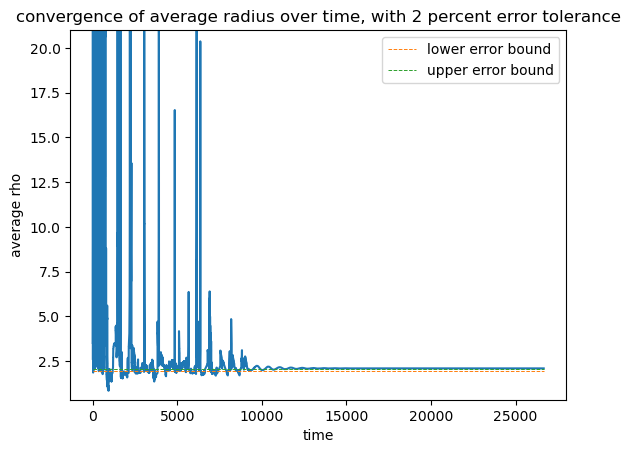

most recent average radius is [2.09052306]


In [4378]:
#plots average rotational radius
tol = 0.02
bound = [rho_e + rho_e * tol, rho_e - rho_e * tol]

theta_dot_save = np.array(theta_dot_save)
rho = abs(v / theta_dot_save) 
avg_rho = np.empty([rho.shape[0], 1])
time = np.arange(0,T,dt) 

for i in range(rho.shape[0]):
    avg_rho[i] = np.average(rho[i,:])
plt.plot(avg_rho)
plt.plot([0, len(avg_rho)],[bound[1],bound[1]], linestyle = '--', linewidth = 0.7, label = 'lower error bound')
plt.plot([0, len(avg_rho)],[bound[0],bound[0]], linestyle = '--', linewidth = 0.7, label = 'upper error bound')
ax = plt.gca()
ax.set_ylim([min(avg_rho)-0.5, 21])

#Error_percent = abs(avg_rho-solution.root) / solution.root * 100 



plt.xlabel('time')
plt.ylabel('average rho')
ax.legend()
ax.set_title('convergence of average radius over time, with 2 percent error tolerance')
plt.show()
print(f"most recent average radius is {avg_rho[-1]}")

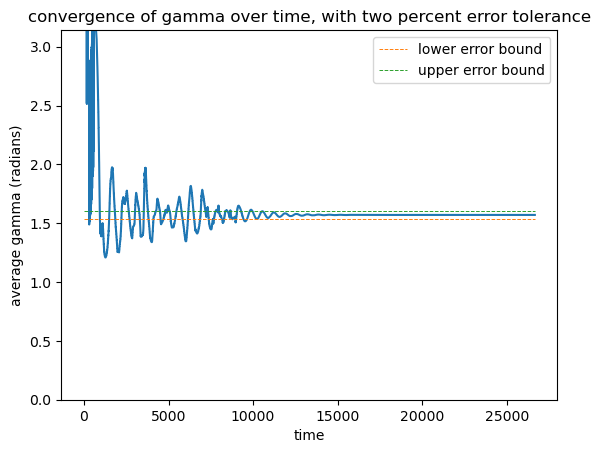

In [4379]:
#plots average gamma vs time
bound_gamma = [np.pi/2 + np.pi/2 * tol, np.pi/2 - np.pi/2 * tol]
gamma_save = np.array(gamma_save)
avg_gamma = np.empty([gamma_save.shape[0],1])

for i in range(gamma_save.shape[0]):
    avg_gamma[i] = np.average(gamma_save[i,:])
plt.plot(avg_gamma)
plt.plot([0, len(avg_gamma)],[bound_gamma[1],bound_gamma[1]], linestyle = '--', linewidth = 0.7, label = 'lower error bound')
plt.plot([0, len(avg_gamma)],[bound_gamma[0],bound_gamma[0]], linestyle = '--', linewidth = 0.7, label = 'upper error bound')
plt.xlabel('time')
plt.ylabel('average gamma (radians)')
ax = plt.gca()
ax.set_ylim(0,np.pi)
ax.legend()
ax.set_title('convergence of gamma over time, with two percent error tolerance')
plt.show()



## Safety Analysis 

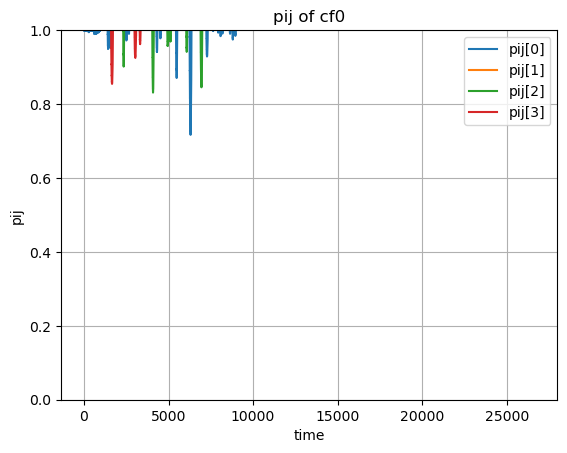

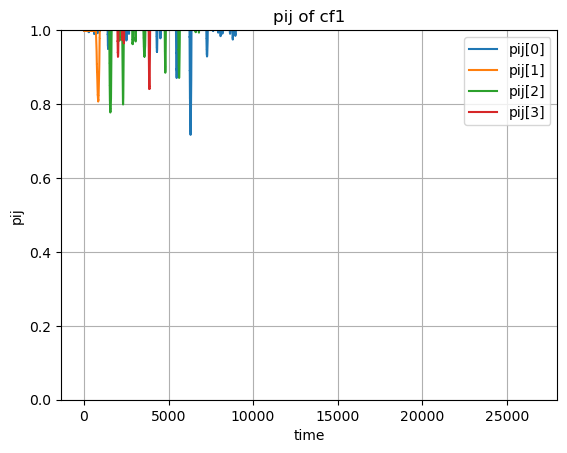

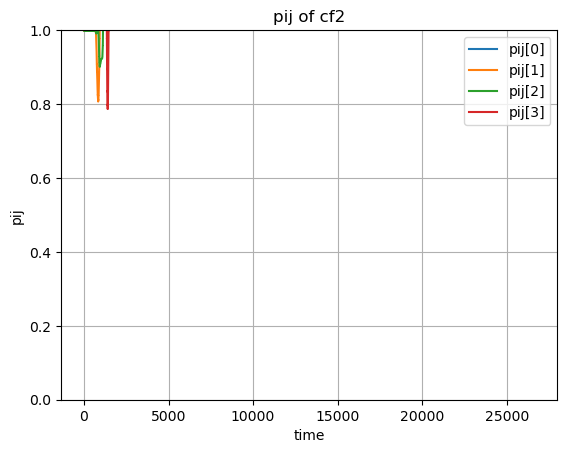

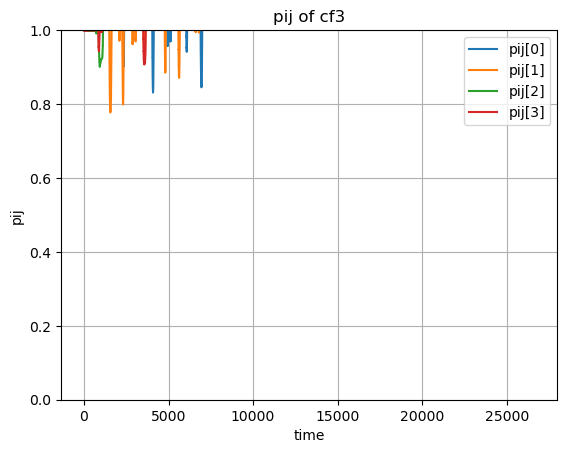

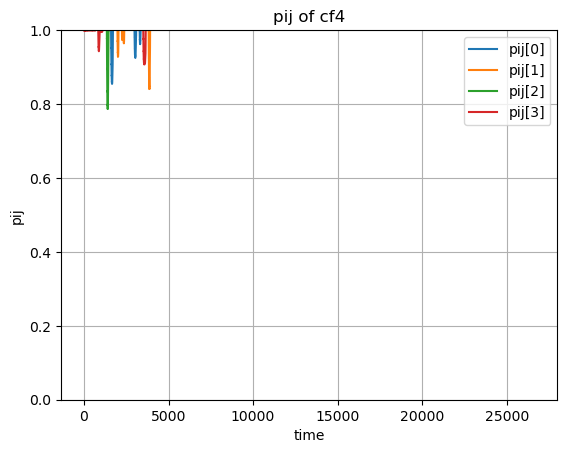

In [4380]:

for i in range(n):
    for j in range(n-1):
        plt.plot([element[j] for element in np.array(pij_vec_3d)[:,i]],label = f"pij[{j}]")
        plt.title(f"pij of cf{i}")
        plt.xlabel('time')
        plt.ylabel('pij')
        plt.grid(True)
        plt.ylim(0,1)
    plt.legend()
    plt.show()

## comparison between visible/ uij/ pij

,visible_agent0,pij_agent0,uij_agent0,visible_agent1,pij_agent1,uij_agent1,visible_agent2,pij_agent2,uij_agent2,visible_agent3,pij_agent3,uij_agent3,visible_agent4,pij_agent4,uij_agent4
0,"[False, False, False, False]","[1.0, 2.0, 2.9999999999999996, 3.9999999999999...",0.000000,"[False, False, False, False]","[1.0, 1.0, 1.9999999999999996, 2.9999999999999...",0.000000,"[False, False, True, False]","[2.0, 1.0, 0.9999999999999996, 1.9999999999999...",-0.221499,"[False, False, True, False]","[2.9999999999999996, 1.9999999999999996, 0.999...",0.221499,"[False, False, False, False]","[3.9999999999999996, 2.9999999999999996, 1.999...",0.000000
1,"[False, False, False, False]","[1.0, 2.0, 2.9999999999999996, 3.9999999999999...",0.000000,"[False, False, False, False]","[1.0, 1.0, 1.9999999999999996, 2.9999999999999...",0.000000,"[False, False, True, False]","[2.0, 1.0, 0.9999999999999996, 1.9999999999999...",-0.225380,"[False, False, True, False]","[2.9999999999999996, 1.9999999999999996, 0.999...",0.221897,"[False, False, False, False]","[3.9999999999999996, 2.9999999999999996, 1.999...",0.000000
2,"[True, False, False, False]","[0.9999317625464881, 1.9994912068349568, 3.000...",-0.222190,"[True, True, False, False]","[0.9999317625464881, 0.9995594443020751, 2.000...",-0.002262,"[False, True, False, False]","[1.9994912068349568, 0.9995594443020751, 1.000...",0.217722,"[False, False, False, True]","[3.0001739577149737, 2.000242195168672, 1.0006...",-0.221179,"[False, False, False, True]","[3.9997382012537717, 2.99980643870733, 2.00024...",0.219284
3,"[True, False, False, False]","[0.9998660922524633, 1.9989897214171248, 3.000...",-0.227582,"[True, True, False, False]","[0.9998660922524633, 0.9991236292174877, 2.000...",-0.004621,"[False, True, False, False]","[1.9989897214171248, 0.9991236292174877, 1.001...",0.223319,"[False, False, False, True]","[3.000341842789883, 2.000475750538114, 1.00135...",-0.230234,"[False, False, False, True]","[3.999487893463226, 2.9996218012109304, 2.0004...",0.221703
4,"[False, False, False, False]","[1.000112546865046, 1.9997355589294594, 3.0000...",0.000000,"[False, True, False, False]","[1.000112546865046, 0.999623012123026, 1.99998...",-0.223794,"[False, True, False, False]","[1.9997355589294594, 0.999623012123026, 1.0003...",0.218521,"[False, False, False, True]","[3.000095586027356, 1.9999830392061715, 1.0003...",-0.225388,"[False, False, False, True]","[3.999980533383652, 2.999867986532614, 2.00024...",0.219241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26659,"[True, False, False, False]","[2.452500272305955, 2.4569099553404694, 3.9713...",-0.014563,"[False, False, True, False]","[2.452500272305955, 3.9849152931354213, 2.4670...",-0.014029,"[True, False, False, False]","[2.4569099553404694, 3.9849152931354213, 3.981...",-0.014581,"[False, False, False, True]","[3.971344178835352, 2.467026925424078, 3.98140...",-0.014893,"[False, False, True, False]","[3.967497819347261, 3.976697634431372, 2.46280...",-0.014062
26660,"[True, False, False, False]","[2.452500321058348, 2.456910021812995, 3.97134...",-0.014563,"[False, False, True, False]","[2.452500321058348, 3.9849153807177684, 2.4670...",-0.014029,"[True, False, False, False]","[2.456910021812995, 3.9849153807177684, 3.9814...",-0.014581,"[False, False, False, True]","[3.971344278636571, 2.467026984163751, 3.98140...",-0.014893,"[False, False, True, False]","[3.9674979075724575, 3.9766977154150682, 2.462...",-0.014062
26661,"[True, False, False, False]","[2.4525199097372044, 2.457210340882287, 3.9716...",-0.014564,"[False, False, True, False]","[2.4525199097372044, 3.985100980997861, 2.4672...",-0.014019,"[True, False, False, False]","[2.457210340882287, 3.985100980997861, 3.98174...",-0.014568,"[False, False, False, True]","[3.971697006901277, 2.4672171859645724, 3.9817...",-0.014887,"[False, False, True, False]","[3.9676832273516256, 3.9767780951481453, 2.462...",-0.014061
26662,"[True, False, False, False]","[2.452234742803

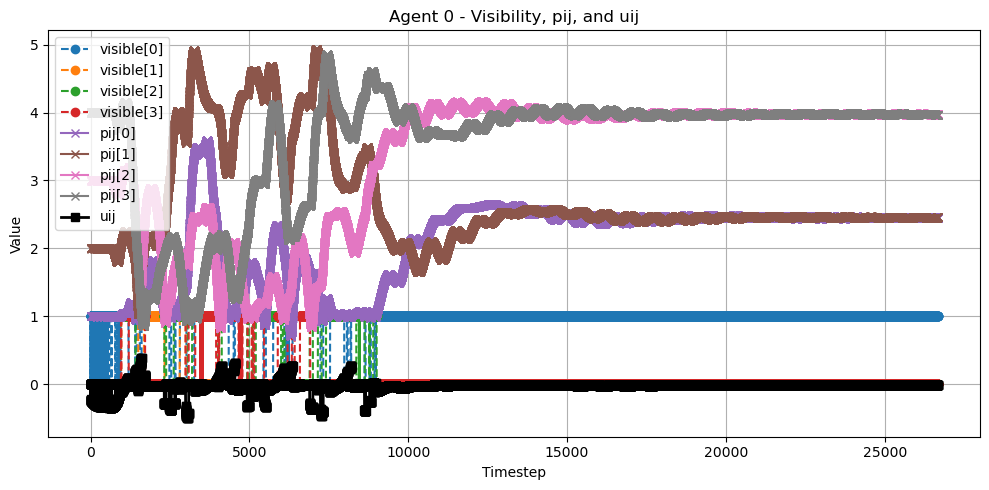

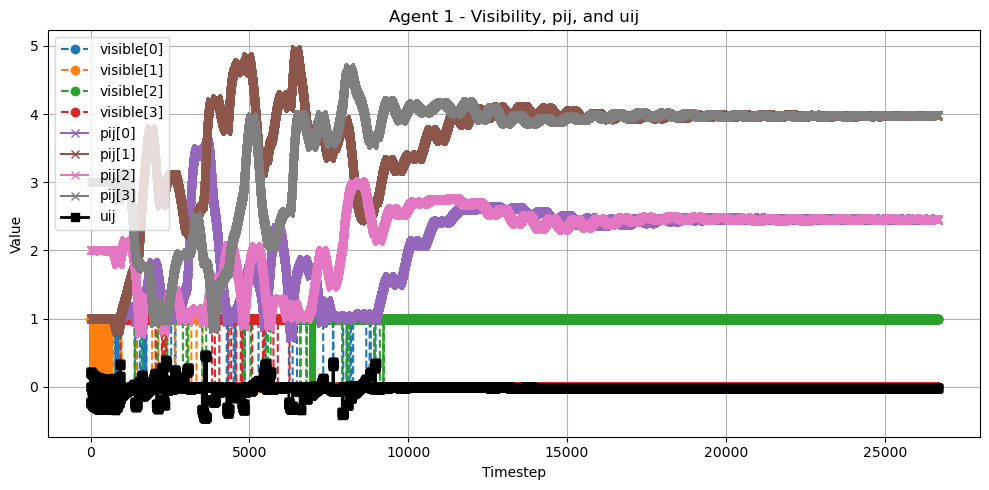

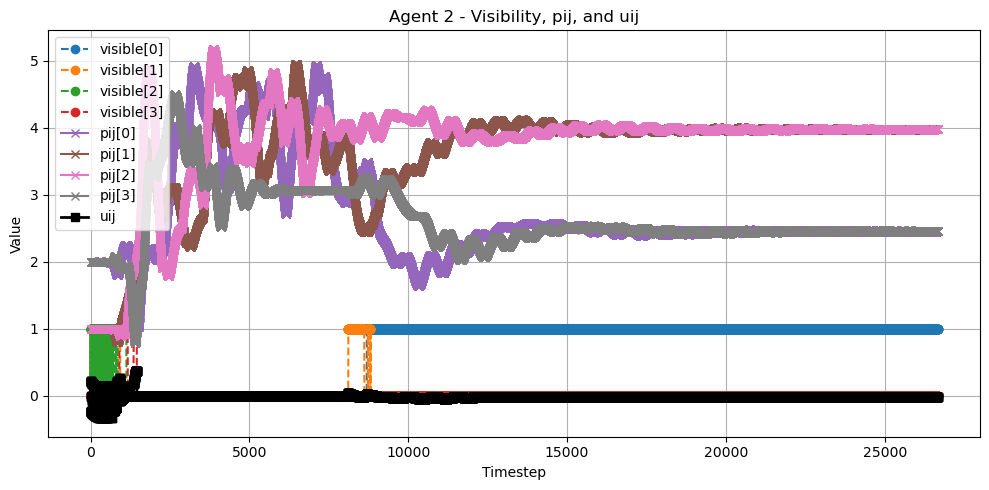

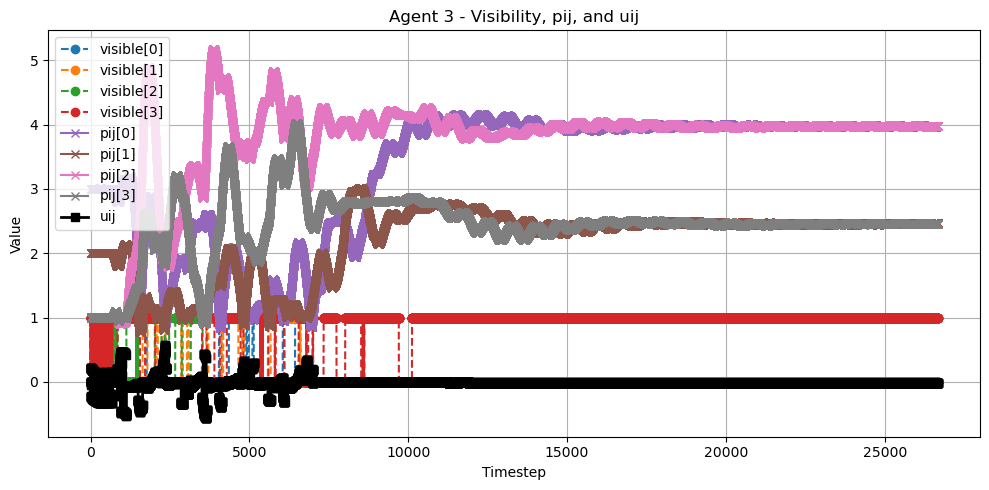

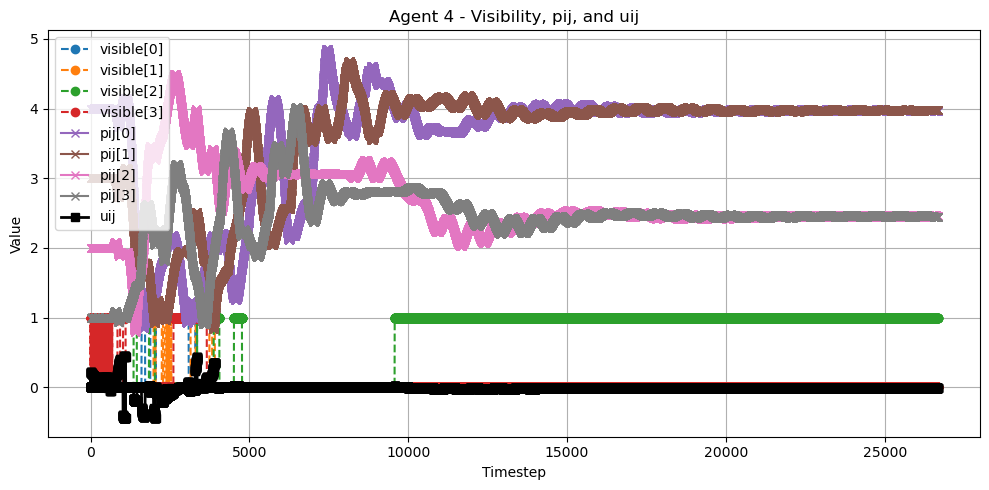

In [4381]:
# visible/ coordinates/ pij_vec_3d
from IPython.display import display
vis_zone_vec_2_tab = np.array(vis_zone_vec_2)
pij_vec_3d_tab = np.array(pij_vec_3d)
utj_vec_tab = np.array(utj_vec)
tab = []
for i in range(n):
    table = {"visible": [element for element in vis_zone_vec_2_tab[0:,i]],
            "pij": [element for element in pij_vec_3d_tab[0:,i]],
            "uij":utj_vec_tab[0:,i]}
    tab.append(pd.DataFrame(table))
    
agent_dfs = []

for i, df in enumerate(tab):
    df_copy = df.copy()
    df_copy.columns = [f'{col}_agent{i}' for col in df.columns]
    agent_dfs.append(df_copy)

wide_df = pd.concat(agent_dfs, axis=1)
display(wide_df)

# import matplotlib.pyplot as plt

for agent_idx, df in enumerate(tab):
    visible_arr = np.array(df['visible'].tolist())  # shape: (timesteps, other_agents)
    pij_arr = np.array(df['pij'].tolist())          # shape: (timesteps, other_agents)
    uij_arr = df['uij'].values                      # shape: (timesteps,)
    timesteps = np.arange(len(df))
    
    plt.figure(figsize=(10, 5))

    # Plot visibility (binary: 0 or 1)
    for j in range(visible_arr.shape[1]):
        plt.plot(timesteps, visible_arr[:, j], label=f'visible[{j}]', linestyle='--', marker='o')

    # Plot pij
    for j in range(pij_arr.shape[1]):
        plt.plot(timesteps, pij_arr[:, j], label=f'pij[{j}]', linestyle='-', marker='x')

    # Plot uij
    plt.plot(timesteps, uij_arr, label='uij', color='black', linewidth=2, marker='s')

    plt.title(f'Agent {agent_idx} - Visibility, pij, and uij')
    plt.xlabel('Timestep')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    # plt.xlim([500,600])
    plt.show()
    


